In [75]:
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import numpy as np
import pandas as pd

df = pd.read_parquet("../data/regular_ot_pbp.parquet")

df = df.drop("time_remaining", axis=1)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

one_hot = pd.get_dummies(df, columns=["event", "team", "event_zone", "home_zone", "strength"])
grouped = one_hot.groupby(["season", "game"])

window_size = 3
windows = []
targets = []

# create sliding window within each game
for group_name, group in tqdm(grouped, total=len(grouped)):
    temp_window = []
    target = group["winner"].iloc[0]  # same for all in group

    for row in group.drop("winner", axis=1).itertuples(index=False):
        feature_values = list(row)[2:]  # skip season and game columns
        temp_window.append(feature_values)

        if len(temp_window) == window_size:
            windows.append(temp_window.copy())
            targets.append(target)
            temp_window.pop(0)

X = np.array(windows)

encoder = LabelEncoder()
y = encoder.fit_transform(np.array(targets))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

100%|██████████| 2564/2564 [00:05<00:00, 511.97it/s]


In [77]:
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Input(shape=(window_size, X.shape[2])),
    LSTM(16),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005, clipvalue=1.0))

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7163 - val_loss: 0.6926
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6921 - val_loss: 0.6925
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6919 - val_loss: 0.6926
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6919 - val_loss: 0.6926
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6920 - val_loss: 0.6909
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6906 - val_loss: 0.6902
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6899 - val_loss: 0.6898
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6896 - val_loss: 0.6892
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6892 - val_loss: 0.6895
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6886 - val_loss: 0.6880
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6881 - val_loss: 0.6892
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

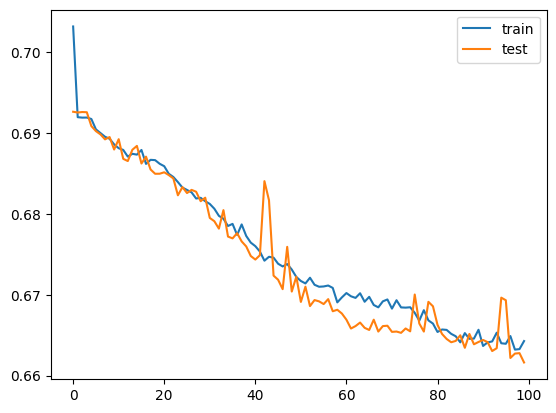

In [78]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [79]:
# adapted from https://stackoverflow.com/a/58598737
# given that the end goal is win probability over time and not predicting the victor,
# this is not a fair measure of the model
# especially difficult with overtime

from sklearn.metrics import confusion_matrix
from numpy import round

predictions = model.predict(X_test)
y_pred = round(predictions)

cm = confusion_matrix(y_test, y_pred)

total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : %.6f' % accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : %.6f' % sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : %.6f' % specificity)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.613024
Sensitivity : 0.675152
Specificity : 0.555155


In [81]:
model.save("models/meter_reg_ot_lstm16.keras")